<a href="https://colab.research.google.com/github/wdon021/From_Colab/blob/master/ImageEnhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
!pip install torchvision==0.1.9
!pip install fastai==0.7.0
!pip install torchtext==0.2.3

     |████████████████████████████████| 51kB 1.7MB/s 
  Found existing installation: torchvision 0.4.2
    Uninstalling torchvision-0.4.2:
      Successfully uninstalled torchvision-0.4.2
     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 1.5MB 8.4MB/s 
     |████████████████████████████████| 496.4MB 24kB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl size=2662709 sha256=bc4d9e03f22854f8ab2854fc221f62077e8a73fd2c2c3ee0aca3d9349eb25fb2
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1
  Found existing installation: fastai 1.0.60
    Uninstalling fastai-1.0.60:
      Successfully uninstalled fastai-1.0.60
     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for torchtext: filename=torchtext-0.2.3-cp36-

In [0]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
torch.backends.cudnn.benchmark=True

In [0]:
PATH = "/content/gdrive/My Drive/ImageEnhancement/"

In [0]:
PATH = Path('/content/gdrive/My Drive/ImageEnhancement')
PATH_TRN = PATH/'train'

In [6]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:43<00:00, 12699874.19it/s]


In [0]:
img_fn = PATH_TRN/'n01440764'/'20200102_214655.jpg'
img = open_image(img_fn)
img = np.rot90(img, k=1, axes=(0, 1))

In [0]:
sz=288

In [9]:
trn_tfms, val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)
img_tfm.shape

(3, 288, 288)

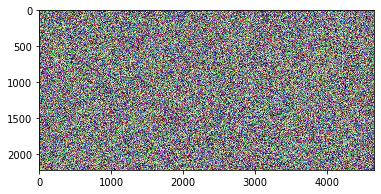

In [10]:
opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
plt.imshow(opt_img)

In [0]:
opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])

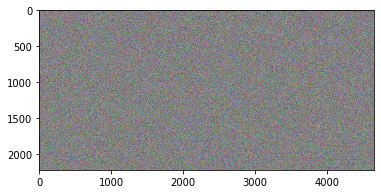

In [12]:
plt.imshow(opt_img)

In [13]:
opt_img = val_tfms(opt_img)/2
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 288, 288])

In [0]:
m_vgg = nn.Sequential(*children(m_vgg)[:37])

In [15]:
targ_t = m_vgg(VV(img_tfm[None]))
targ_v = V(targ_t)
targ_t.shape

torch.Size([1, 512, 18, 18])

In [0]:

max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [0]:
def actn_loss(x): return F.mse_loss(m_vgg(x), targ_v)*1000

In [0]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [19]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss))

Iteration: 100, loss: 0.7921060919761658
Iteration: 200, loss: 0.39843666553497314
Iteration: 300, loss: 0.2825803756713867
Iteration: 400, loss: 0.22788675129413605
Iteration: 500, loss: 0.19436676800251007
Iteration: 600, loss: 0.17401579022407532
Iteration: 700, loss: 0.16032803058624268
Iteration: 800, loss: 0.1499328464269638
Iteration: 900, loss: 0.1420709788799286
Iteration: 1000, loss: 0.13549105823040009


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


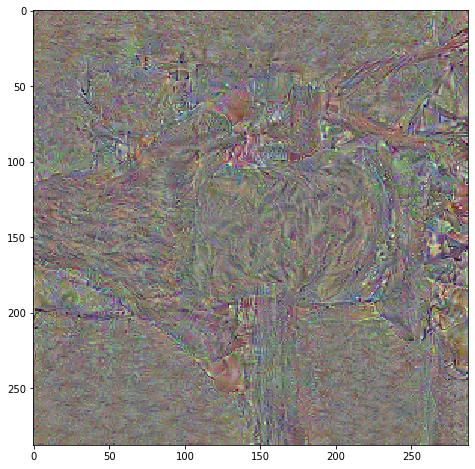

In [20]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(8,8))
plt.imshow(x)

forward hook

In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [0]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

In [23]:
block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

In [0]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])

In [0]:
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

In [0]:
opt_img_v, optimizer = get_opt()

In [27]:
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 36, 36])

In [0]:
def actn_loss2(x):
    m_vgg(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*1000

In [29]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

Iteration: 100, loss: 0.275898814201355
Iteration: 200, loss: 0.1350797712802887
Iteration: 300, loss: 0.09300573915243149
Iteration: 400, loss: 0.07214979082345963
Iteration: 500, loss: 0.059406816959381104
Iteration: 600, loss: 0.051157403737306595
Iteration: 700, loss: 0.04534604772925377
Iteration: 800, loss: 0.041006941348314285
Iteration: 900, loss: 0.03759139031171799
Iteration: 1000, loss: 0.034850262105464935


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


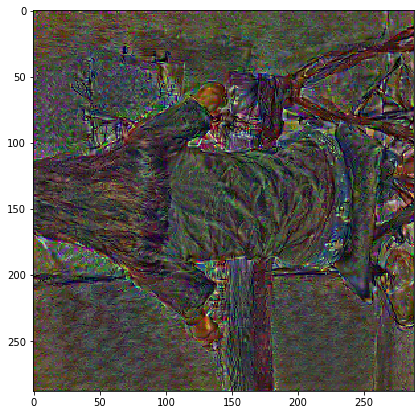

In [30]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [0]:
sf.close()

style match

In [32]:
# !wget -O /content/gdrive/My\ Drive/ImageEnhancement/starry_night.jpg https://raw.githubusercontent.com/jeffxtang/fast-style-transfer/master/images/starry_night.jpg

--2020-02-03 00:08:54--  https://raw.githubusercontent.com/jeffxtang/fast-style-transfer/master/images/starry_night.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 583974 (570K) [image/jpeg]
Saving to: ‘/content/gdrive/My Drive/ImageEnhancement/starry_night.jpg’

/content/gdrive/My  100%[===================>] 570.29K  --.-KB/s    in 0.09s   

2020-02-03 00:08:55 (6.20 MB/s) - ‘/content/gdrive/My Drive/ImageEnhancement/starry_night.jpg’ saved [583974/583974]



In [0]:
style_fn = '/content/gdrive/My Drive/ImageEnhancement/starry_night.jpg'

In [36]:
style_img = open_image(style_fn)
style_img.shape, img.shape

((500, 800, 3), (2218, 4656, 3))

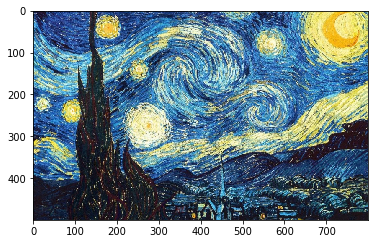

In [37]:
plt.imshow(style_img)

In [0]:
def scale_match(src, targ):
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    rat = max(h/sh,w/sw); rat
    res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [0]:
style = scale_match(img, style_img)

((2218, 4656, 3), (2218, 4656, 3))

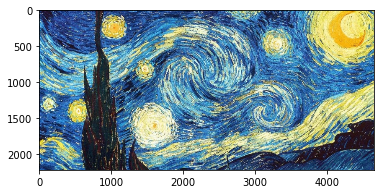

In [42]:
plt.imshow(style)
style.shape, img.shape

In [0]:
opt_img_v, optimizer = get_opt()

In [0]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [45]:
m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [0]:
style_tfm = val_tfms(style_img)

In [48]:
m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [0]:
def gram(input):
  b,c,h,w = input.size()
  x = input.view(b*c, -1)
  return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

In [0]:
def style_loss(x):
  m_vgg(opt_img_v)
  outs = [V(o.features) for o in sfs]
  losses = [gram_mse_loss(o,s) for o,s in zip(outs, targ_styles)]
  return sum(losses)

In [51]:
n_iter = 0
while n_iter <= max_iter: optimizer.step(partial(step, style_loss))

Iteration: 100, loss: 539.0038452148438
Iteration: 200, loss: 142.2276611328125
Iteration: 300, loss: 46.449703216552734
Iteration: 400, loss: 21.652772903442383
Iteration: 500, loss: 13.90572452545166
Iteration: 600, loss: 10.671852111816406
Iteration: 700, loss: 9.031442642211914
Iteration: 800, loss: 7.996133804321289
Iteration: 900, loss: 7.270062446594238
Iteration: 1000, loss: 6.7237043380737305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


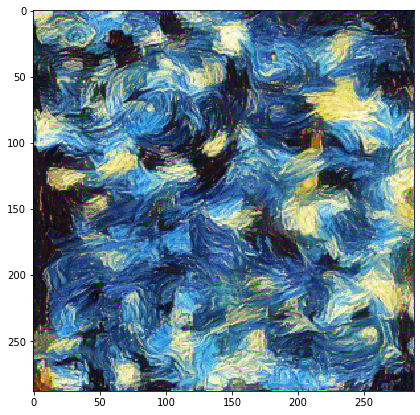

In [53]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x)